**ASPIRE [WALKSCORE]**

Created By: Amiri Hayes

Last Updated: 12/13/2023

Contact: akh5 @ njit.edu

See More: [HERE](https://docs.google.com/document/d/1_duLvb0bc4aiwkd2l77qgaJ-9fTVcpFi38nCUwXTNWk/edit)

Imports & Stuff:

In [1]:
# Install some packages:
!pip install osmnx
!apt install libspatialindex-dev
%pip install torch
%pip install tqdm
%pip install geopy
%pip install random

The operation couldn’t be completed. Unable to locate a Java Runtime that supports apt.
Please visit http://www.java.com for information on installing Java.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement random (from versions: none)
ERROR: No matching distribution found for random
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports for requests:
import os
import json
import requests
import numpy as np
from glob import glob
from tqdm import tqdm

In [3]:
import os
import json

# Directory containing JSON files
json_dir = '/Users/amirih./Desktop/research/ASPIRE_Codebase/WalkScore/assets'

# Function to find the three highest values and their corresponding city information
def find_highest_values_with_city_info(json_dir):
    scores_with_info = []

    # Iterate over JSON files
    for filename in os.listdir(json_dir):
        if filename.endswith('.json'):
            with open(os.path.join(json_dir, filename), 'r') as file:
                data = json.load(file)
                if 'walk_score_lr' in data:
                    score = data['walk_score_lr']
                    city_info = {
                        'city_neighborhood': data.get('city_neighborhood', ''),
                        'city_name': data.get('city_name', ''),
                        'city_state': data.get('city_state', '')
                    }
                    scores_with_info.append((score, city_info))

    # Sort by score
    scores_with_info.sort(key=lambda x: x[0], reverse=True)

    # Select the top three
    top_three = scores_with_info[:3]

    return top_three

# Call the function and print the highest values and their corresponding city information
highest_values_with_info = find_highest_values_with_city_info(json_dir)
for i, (score, city_info) in enumerate(highest_values_with_info, start=1):
    print(f"{i}. Walk Score: {score}, City: {city_info['city_name']}, Neighborhood: {city_info['city_neighborhood']}, State: {city_info['city_state']}")


1. Walk Score: 112.88139616640632, City: San Diego, Neighborhood: Gaslamp Quarter, State: CA
2. Walk Score: 112.09535428798785, City: New York, Neighborhood: Greenwich Village, State: NY
3. Walk Score: 110.53782725107243, City: New York, Neighborhood: Nolita, State: NY


In [13]:
# Imports for features:
import random
import osmnx as ox
import numpy as np
import pandas as pd
import networkx as nx
from geopy import geocoders
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
G = geocoders.GeoNames(username='amiri_hayes_')

In [ ]:
# Example of a Geocode Array
print(G.geocode('New York, NY')[-1])

In [ ]:
# Example of an OSMNX Graph Network
graph = ox.graph_from_place("Newark, NJ", network_type="drive")
fig, ax = ox.plot_graph(graph, filepath = "assets/a_newark.png")

Create Training Data:

In [17]:
df = pd.read_csv('../cities.csv', delimiter='\t')
df.head()
# import csv
# csv_file_path = '../cities.csv'

# # Writing to CSV file with a tab as delimiter
# with open(csv_file_path, 'w', newline='') as csv_file:
#     csv_writer = csv.writer(csv_file, delimiter='\t')
    
#     # Write the header if needed
#     # csv_writer.writerow(['Column1', 'Column2', 'Column3'])  # Replace with your column names
    
#     # Write the data from the list of tuples
#     csv_writer.writerows(cities)

# print(f'CSV file has been created at: {csv_file_path}')

,Neighborhood,City,State
0,Ironbound,Newark,NJ
1,Back Bay,Boston,MA
2,Wicker Park,Chicago,IL
3,Capitol Hill,Denver,CO
4,Haight-Ashbury,San Francisco,CA


In [15]:
# What cities do you want to score the walking infrastructure of?
# This will be the training set for the model:
cities = pd.read_csv('../cities.csv', delimiter='\t')
print("Training Data Size is", len(cities))

Training Data Size is 100


In [ ]:
def create_city_database(city, cache = False):
  db = {}
  city_neighborhood, city_name, city_state = city

  # ACCESS & GEOGRAPHIC INFO
  db["city_name"] = city_name
  db["city_state"] = city_state
  db["city_neighborhood"] = city_neighborhood
  db["coordinates"] = G.geocode(', '.join(city))[-1]
  db["timezone"] = G.reverse_timezone(db["coordinates"])._raw["timezoneId"]

  cached_file = f'assets/{city_neighborhood.replace(" ", "_")}+{city_name.replace(" ", "_")}.json'
  if cache and os.path.exists(cached_file):
    with open(cached_file) as f:  data = json.load(f)
    # Edit the existing file ->
    # [data["proximity"], data["bike_viability"]] = get_proximity(city)
    with open(cached_file, 'w') as f: f.write(json.dumps(data, indent=4, sort_keys=True))
    return data

  # QUANTITATIVE FEATURES (to be weighted)
  db["infrastructure"] = get_infrastructure(db["coordinates"])
  db["environment"] = get_weather(db["coordinates"], db["timezone"])
  db["crime_info"] = get_crime(db["city_state"])

  # WALK SCORE OUTPUT
  [db["walk_proximity"], db["bike_proximity"]] = get_proximity(city)
  db["connectivity"] = get_connectivity(db["coordinates"])

  if cache: # save dictionary as json file ->
    json_str = json.dumps(db, indent=4, sort_keys=True)
    with open(cached_file, 'w') as f: f.write(json_str)

  return db

Feature collecting functions:

In [17]:
# Infrastructure Graph (Features: 1 / 3)
    # Source: OpenStreetMapsNX
    # Docs: https://osmnx.readthedocs.io/en/stable/
    # Description: returns graph degree centrality [0, ∞]

def get_infrastructure(center):
  g = ox.graph_from_point(center_point=center, dist=1000, network_type="walk")
  fig, ax = ox.plot_graph(g)
  g = nx.Graph(g)

  centrality_values = nx.degree_centrality(g)
  centrality = sum(centrality_values.values()) / len(centrality_values)
  degree = sum(dict(g.degree()).values()) / g.number_of_nodes()
  density = nx.density(g)
  efficiency = nx.global_efficiency(g)
  closeness = max(nx.closeness_centrality(g).values())

  map_info = [centrality, degree, density , efficiency, closeness]
  return map_info

In [9]:
# Weather & Sunset Data (Features: 2 / 3)
    # Source: Open Meteo
    # Docs: https://open-meteo.com/en/docs
    # Description: returns weather + sunset score [0, 1]

def get_weather(coords, timezone):
  tz = timezone.replace("/", "%2F")
  weather_data = []

  URL = f"https://api.open-meteo.com/v1/forecast?latitude={coords[0]}&longitude={coords[1]}&daily=sunset&timezone={tz}&past_days=14&hourly=temperature_2m,relativehumidity_2m,windspeed_10m,rain&temperature_unit=fahrenheit"
  response = requests.get(url = URL).json()

  if response:
    # Weather ->
    temp_avg = round(sum(response["hourly"]["temperature_2m"]) / len(response["hourly"]["temperature_2m"]), 2)
    humidity_avg = round(sum(response["hourly"]["relativehumidity_2m"]) / len(response["hourly"]["relativehumidity_2m"]), 2)
    windspeed_avg = round(sum(response["hourly"]["windspeed_10m"]) / len(response["hourly"]["windspeed_10m"]), 2)
    rain_avg = round(sum(response["hourly"]["rain"]) / len(response["hourly"]["rain"]), 2)

    # Sunset ->
    sunset_seconds, ftr = [], [60, 1]
    sunset_res = [val.split("T")[1] for val in response["daily"]["sunset"]]
    for val in sunset_res:
      sunset_seconds.append(sum([a*b for a,b in zip(ftr, map(int,val.split(':')))]))
    sunset_avg = round(sum(sunset_seconds) / len(sunset_seconds), 2)

    weather_data = [temp_avg, humidity_avg, windspeed_avg, rain_avg, sunset_avg]

  return weather_data

In [10]:
# Safety Data (Features: 3 / 3)
    # Source: FBI
    # Docs: https://cde.ucr.cjis.gov/LATEST/webapp/#/pages/docApi
    # Description: returns crime per capita of the city input [0, 1]

def get_crime(state):
  api_key = "NFiL07Qb2reRBmseXIecRMpnfEIA7uO6Ps1n7QXS" # get your own at above link plz
  crimes = ["aggravated-assault", "violent-crime", "robbery", "arson",
            "homicide", "burglary", "motor-vehicle-theft", "larceny", "property-crime"]

  crime_stats = []
  for crime in crimes:
    URL = f"https://api.usa.gov/crime/fbi/cde/estimate/state/{state}/{crime}?from=2020&to=2023&API_KEY={api_key}"
    response = requests.get(url = URL).json()

    if response and response["results"] != "null":
      crime_value = -1
      response = response["results"]

      try: crime_stat = next(iter(response.values()))
      except: continue

      crime_stat = next(iter(crime_stat.values()))
      if isinstance(crime_stat, (int, float, complex)) and not isinstance(crime_stat, bool):
          crime_value = crime_stat
    crime_stats.append(crime_value)
    
  return crime_stats

Output collecting functions:

In [ ]:
 # Previous Score Data (Output: 1 / 2)
    # Source: Walk Score
    # Docs: https://www.walkscore.com/professional/api.php
    # Description: returns the trademarked Walk Score value [0, 100]

def get_proximity(city):
  apikey = "9ae2d037ce429437b95c435494d6e126"
  [lat, lon] = G.geocode(', '.join(city))[-1]

  URL = f"https://api.walkscore.com/score?format=json&address=0&lat={lat}&lon={lon}&transit=1&bike=1&wsapikey={apikey}"
  response = requests.get(url = URL).json()

  walkscore, bikescore = -1, -1

  if response["walkscore"]: walkscore = response["walkscore"]
  if response["bike"]: 
    if response["bike"]["score"]:
      bikescore = response["bike"]["score"]

  return (walkscore, bikescore)

In [ ]:
 # Connectivity Data (Output: 2 / 2)
    # Source: OpenStreetMapsNX
    # Docs: https://osmnx.readthedocs.io/en/stable/
    # Description: returns the discrepancy between route length and geographical length [0, 1]

def get_connectivity(center):
  return 0

  g = ox.graph_from_point(center_point=center, dist=1000, network_type="walk")
  nodes = list(g.nodes(data=True))

  # Extract latitude and longitude & store in a list of tuples:
  points_inside_radius = [(node[0][1], node[0][0]) for node in nodes]
  random_10_points = random.sample(points_inside_radius, 50)

  # Determine difference between map's geographic & route distance
  diff = [0] * 25;
  for i in range(0, len(random_10_points), 2):
    origin = random_10_points[i]
    destination = random_10_points[i + 1]

    origin_node = ox.distance.get_nearest_node(graph, origin, method='haversine', return_dist=False)
    destination_node = ox.distance.get_nearest_node(graph, destination, method='haversine', return_dist=False)

    shortest_real = ox.shortest_path(g, origin_node, destination_node, weight="length")
    len_shortest_real = int(sum(ox.utils_graph.route_to_gdf(g, shortest_real, "length")["length"]))
    
    orig_x = G.nodes[origin_node]["x"]
    orig_y = G.nodes[origin_node]["y"]
    dest_x = G.nodes[destination_node]["x"]
    dest_y = G.nodes[destination_node]["y"]
    len_shortest_perfect = round(ox.distance.great_circle(orig_y, orig_x, dest_y, dest_x))
    
    diff.append( (len_shortest_perfect - len_shortest_real) / len_shortest_real )

  return (sum(diff) / 25) * 100

Make the dataset:

In [ ]:
dataset = []
for city in tqdm(cities):
  dataset.append(create_city_database(city, cache = True))
print(json.dumps(dataset, indent=4, sort_keys=True))

In [4]:
# Designate train & test set
for i, json_file in enumerate(glob("assets/*.json")):
  with open(json_file, "r") as file:
    data = json.load(file)
  
  if i < 80: data["category"] = "train"
  else: data["category"] = "test"

  with open(json_file, 'w') as f:
    f.write(json.dumps(data, indent=4, sort_keys=True))   

In [5]:
# Get feature & output data for models
x, y = [], []
for json_file in glob("assets/*.json"):
    with open(json_file, "r") as file:
        city = json.load(file)
        if city["category"] == "train":
            input = city["infrastructure"] + city["environment"] + city["crime_info"]
            output = (city["proximity"]) # + city["connectivity"] / 2

            x.append(input)
            y.append(output)

print("successfully obtained input/output for training")

successfully obtained input/output for training


Linear Regression & Deep Learning Models:

**a\*x + b\*y + c*z = (T1 + T2) / 2**

a, b & c are the weights we'll find!

x: infrastructure degree centrality (what do the maps look like?)

y: weather & sunset score (what is the environment like?)

z: crime per capita value (how safe is it in the area?)

T1: simple walk score (proximity to schools, grocery stores, etc.)

T2: connectivity value (difference between geographic distance & typical walking route length)

In [6]:
# Train Linear Regression model ->
X, y = np.array(x), np.array(y)

linear_model = LinearRegression()
linear_model.fit(X, y)
weights = linear_model.coef_

print("Weight coefficients:", weights)

Weight coefficients: [ 4.18392856e+02  2.56694634e+01  4.18392856e+02 -1.39043642e+02
 -3.86135326e+02  1.96169007e+00  6.02208338e-01 -3.07809063e+00
 -2.42103938e+01 -4.30343089e-01 -2.98928057e-01  1.76353805e-01
 -1.27292428e-01 -2.39513304e-01  2.54578768e+00  9.89543350e-01
  1.17169618e+00  1.17751005e+00 -1.15199112e+00]


In [ ]:
# Train PyTorch Deep Learning model ->
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_tensor = torch.tensor(scaler.fit_transform(X), dtype=torch.float32)
y_tensor = torch.tensor(scaler.fit_transform(y.reshape(-1, 1)), dtype=torch.float32)

class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_size = len(X[1])
model = LinearRegressionModel(input_size)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

num_epochs = 10_000
for epoch in range(num_epochs):
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor.view(-1, 1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(np.array(y).reshape(-1, 1))
print("Trained NN successfully")

Make predictions:

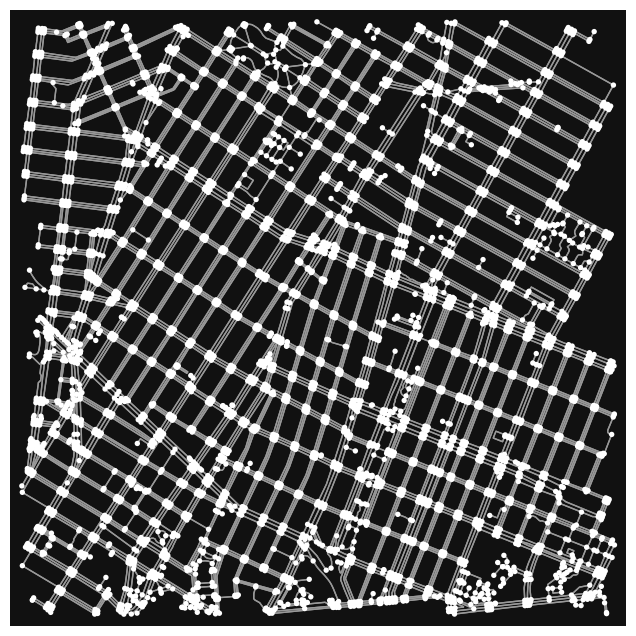

In [30]:
# Predict walkscore for a new city -> 
new_info = {}
new = ("Nolita", "New York", "NY")
new_coordinates = G.geocode(', '.join(new))[-1]
new_timezone = G.reverse_timezone(new_coordinates)._raw["timezoneId"]

new_info["infrastructure"] = get_infrastructure(new_coordinates)
new_info["environment"] = get_weather(new_coordinates, new_timezone)
new_info["crime_info"] = get_crime(new[2])

new_data = np.array(new_info["infrastructure"] + new_info["environment"] + new_info["crime_info"])

In [31]:
# Linear Regression Prediction (1 city) ->
prediction = linear_model.predict([list(new_data)])
print("Predicted value:", prediction[0])

Predicted value: 106.2712346483828


In [ ]:
# Deep Learning Prediction (1 city) ->
scaled_new_data = scaler.fit_transform(new_data.reshape(-1, 1))
new_data_point_tensor = torch.tensor(scaled_new_data, dtype=torch.float32).view(1, -1)

prediction_tensor = model(new_data_point_tensor)
predicted_value_original_scale = target_scaler.inverse_transform(np.array([[prediction_tensor.item()]]))[0, 0]
print("Predicted value:", predicted_value_original_scale)

In [ ]:
# Save predictions for training data ->
for json_file in glob("assets/*.json"):
    with open(json_file, "r") as file: 
        data = json.load(file)
    
    x = np.array(data["infrastructure"] + data["environment"] + data["crime_info"])

    prediction_lr = linear_model.predict([x])
    data["walk_score_lr"] = prediction_lr[0]

    data_tensor = torch.tensor(scaler.fit_transform(x.reshape(-1, 1)), dtype=torch.float32).view(1, -1)
    prediction_tensor = model(data_tensor)
    data["walk_score_nn"] = target_scaler.inverse_transform(np.array([[prediction_tensor.item()]]))[0, 0]

    with open(json_file, 'w') as f:
        f.write(json.dumps(data, indent=4, sort_keys=True))

In [ ]:
# Get Accuracy of Linear & Deep Learning Models
actual, lr_predict, dl_predict = [], [], []

for json_file in glob("assets/*.json"):
    with open(json_file, "r") as file: data = json.load(file)

    if city["category"] == "test":
      actual.append(data["proximity"])
      x = np.array(data["infrastructure"] + data["environment"] + data["crime_info"])

      prediction_lr = linear_model.predict([x])
      lr_predict.append(prediction_lr[0])

      data_tensor = torch.tensor(scaler.fit_transform(x.reshape(-1, 1)), dtype=torch.float32).view(1, -1)
      prediction_tensor = model(data_tensor)
      dl_predict.append(target_scaler.inverse_transform(np.array([[prediction_tensor.item()]]))[0, 0])

mse_lr = mean_squared_error(actual, lr_predict)
mse_dl = mean_squared_error(actual, dl_predict)
print(f"Mean Squared Error (Linear Regression): {mse_lr}")
print(f"Mean Squared Error (Deep Learning): {mse_dl}")

rsquared_lr = r2_score(actual, lr_predict)
rsquared_dl = r2_score(actual, dl_predict)
print(f"R-Squared Error (Linear Regression): {rsquared_lr}")
print(f"R-Squared Error (Deep Learning): {rsquared_dl}")

In [ ]:
# Sensitivity Analysis Check #1

In [ ]:
# Sensitivity Analysis Check #2

Generate Table for Heatmap:

JS Fiddle: https://jsfiddle.net/5u83mbjn/

In [ ]:
json_files = glob("assets/*.json")

information = []
for json_file in json_files:
    with open(json_file, "r") as file:
        data = json.load(file)
        information.append(["US-" + data["city_state"], data["walk_score_nn"]])

df = pd.DataFrame(information, columns=["state", "score"])
average_scores = df.groupby("state")["score"].mean().reset_index()

# Copy & paste this output into the JS Fiddle
for row in average_scores.to_records(index=False):
    print(list(row), ",")